<center>
<img src="https://i.ibb.co/Ycs11Fg/meme.jpg">
</center>

# Андан на экономе: домашнее задание 3
## Задача классификации

## Импорт необходимых библиотек 

Импортируйте все используемые библиотеки здесь.

In [74]:
# Ваш код здесь
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, urllib, json

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.preprocessing import MinMaxScaler

from scipy.interpolate import make_interp_spline, BSpline

import warnings
warnings.filterwarnings("ignore")

## Задача 

В данном задании вам необходимо построить предсказательную модель, определяющую пол клиента по его банковским транзакциям.

Вам доступны 2 файла:
* __transaction.csv__ - файл с транзакциями, колонки:
    * user_id - целочисленный идентификатор пользователя
    * dt - дата и время совершения транзации, принцип кодирования: "DAY TIME"
        * DAY - порядковый день транзации с начала сбора данных
        * TIME - время в формате hh:mm:ss
    * type - тип (категория) совершаемой транзакции
    * value - сумма транзакции
    
* __gender.csv__ - файл с данными о полах клиентов.
    * user_id - целочисленный идентификатор пользователя
    * gender - целевая переменная, закодированная лейблами 0 и 1. Это сделано:
        * a) для удобства
        * б) для избежания холиваров о правильности исходных меток 

Но если вы вдруг захотите похоливарить о том, что метки только две - то заметьте, что о полноте данных мы тоже не утверждаем.

# Часть 1: минималочка [макс 20 баллов]

В этой части мы с вами попробуем построить самую простую модель для предсказания.

Как мы с вами увидим: главная сложность - правильная подготовка данных. В таких задачах то, как именно вы преобразуете данные для обучения модели и будет во много определять её качество.

В этой части мы сделаем простое преобразование данных путём простой агрегации данных о величине транзакций. 

## Загрузка данных [5 баллов] 

Скачайте данные для задачи с Яндекс.Диска:
https://disk.yandex.ru/d/DGy6bbLaMZmrQg.

Загрузите файлы с транзакциями и целевой меткой в pd.DataFrame.

__Внимание__: у файла transactions.csv колоночный разделитель - точка с запятой ";"

In [2]:
# Ваш код здесь
try:
    gender = pd.read_csv("gender.csv")
except:
    folder_url = 'https://disk.yandex.ru/d/DGy6bbLaMZmrQg'
    file_url = 'gender.csv'
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)

    r = requests.get(url) # запрос ссылки на скачивание
    h = json.loads(r.text)['href'] # 'парсинг' ссылки на скачивание

    gender = pd.read_csv(h, sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

gender["gender"] = gender["gender"].astype("int64") 
gender

,user_id,gender
0,6740969,1
1,36599781,0
2,91453656,1
3,17431962,1
4,72568668,1
...,...,...
8395,93715144,1
8396,51502229,0
8397,77655748,1
8398,87819773,1


In [3]:
# Ваш код здесь
try:
    transactions = pd.read_csv("transactions.csv", sep=";")

except:
    folder_url = 'https://disk.yandex.ru/d/DGy6bbLaMZmrQg'
    file_url = 'transactions.csv'
    url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)

    r = requests.get(url) # запрос ссылки на скачивание
    h = json.loads(r.text)['href'] # 'парсинг' ссылки на скачивание

    transactions = pd.read_csv(h, sep=';', error_bad_lines=False, comment='#')
transactions

,user_id,dt,type,value
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099
...,...,...,...,...
2282462,71902723,290 15:12:09,Агенты и менеджеры по аренде недвижимости,2133.620
2282463,71942984,248 00:00:00,Агенты и менеджеры по аренде недвижимости,1870.848
2282464,71942984,375 00:00:00,Агенты и менеджеры по аренде недвижимости,2466.016
2282465,74289663,27 00:00:00,Агентства по аренде автомобилей,1445.831


## Подготовка данных [10 баллов] 

Для данной задачи необходимо как-то собрать данные для каждого пользователя в один вектор (строку таблицы). Сейчас, как вы можете увидеть, в таблице с данными одному пользователю может соответствовать много строк (каждая операция - отдельная строка).

Таким образом, необходима агрегация данных - это можно сделать множеством разных способов.

### Агрегация 

Произведите простую агрегацию данных и для каждого пользователя в качестве признаков получите сумму, среднее и стандартное отклонение величины его транзакций. 

Так же добавите для каждого пользователя колонку с таргетом.

По итогу вы должны получить таблицу с колонками:
* user_id
* value_sum
* value_mean
* value_std
* gender

In [4]:
# Ваш код здесь
gender_index = gender.set_index('user_id')
agg_data = transactions.pivot_table(index='user_id', values='value', aggfunc=['sum', 'mean', 'std'])
agg_data.columns = ['value_sum', 'value_mean', 'value_std']
agg_data['gender'] = gender_index['gender']
agg_data

,value_sum,value_mean,value_std,gender
user_id,,,,
22899,274383.315,2143.619648,656.186785,1
27914,166436.523,2521.765500,415.972053,1
28753,251578.185,1980.930591,749.304999,0
31385,717856.052,2323.158744,632.491585,0
38084,1360028.958,2095.576206,649.030870,0
...,...,...,...,...
99953525,159252.786,1608.614000,709.903466,0
99967537,13026.313,2605.262600,123.013557,1
99988578,1304612.429,2185.280451,638.235664,1


<div class="alert alert-success">
   Проанализируем пропуски и дубликаты
</div>

In [5]:
agg_data.isna().sum()

value_sum      0
value_mean     0
value_std     47
gender         0
dtype: int64

In [6]:
agg_data.duplicated().sum()

25

<div class="alert alert-success">
  Т.к у нас всего <b>47</b> нулевых значений и <b>25</b> явных дубликатов, а в сумме это меньше <b>1%</b> от исходного размера датасета, то проще будет их просто удалить их датасета,  чтобы никак не исказить результат исследования
</div>

In [7]:
agg_data.drop_duplicates(inplace=True)
agg_data.dropna(inplace=True)

In [8]:
agg_data.isna().sum()

value_sum     0
value_mean    0
value_std     0
gender        0
dtype: int64

In [9]:
agg_data.duplicated().sum()

0

<div class="alert alert-success">
     Теперь посмотрим на распредение целевых классов и как выглядит график изменения наших признаков
</div>

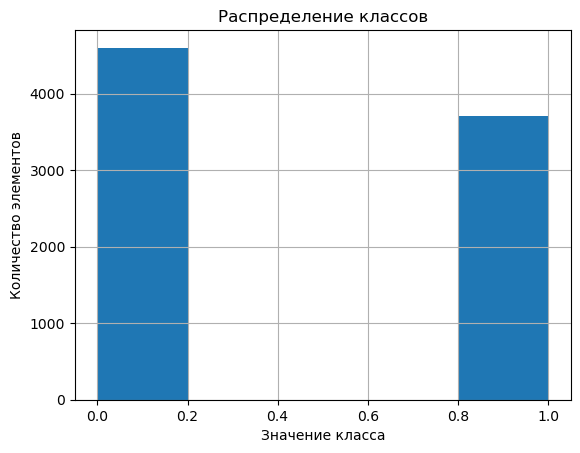

In [10]:
agg_data["gender"].hist(bins=5)
plt.xlabel("Значение класса")
plt.ylabel("Количество элементов")
plt.title("Распределение классов")
plt.show();

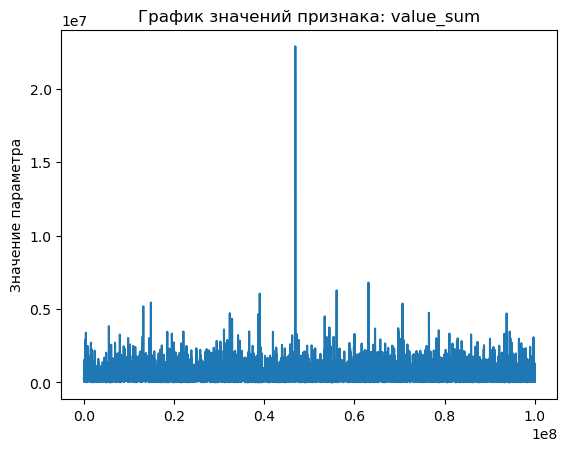

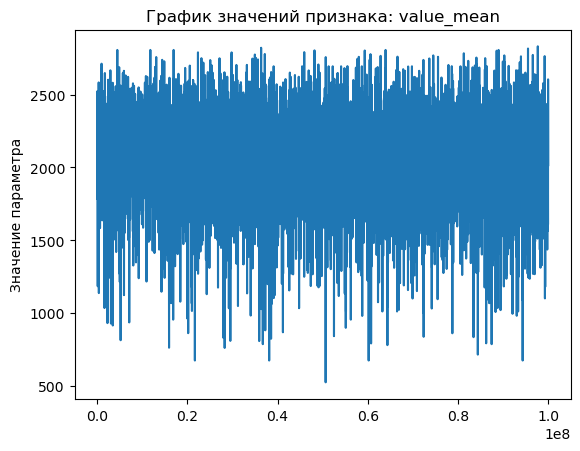

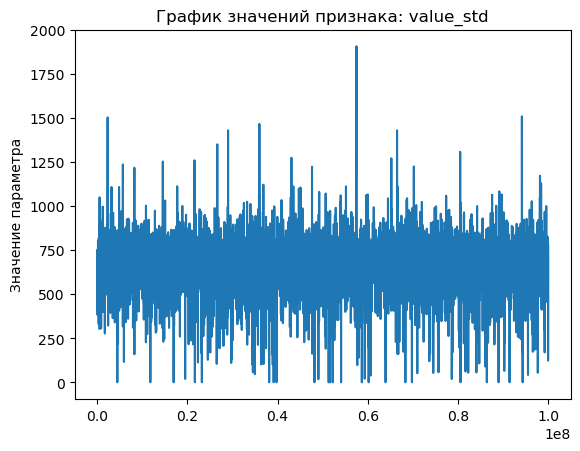

In [11]:
for feature in agg_data.columns[:-1]:
    plt.plot(agg_data[feature])
    plt.title(f"График значений признака: {feature}")
    plt.ylabel("Значение параметра")
    plt.show();

<div class="alert alert-success">
     Если во всех признаках все в целом более менее красиво, то вот в признаке <b>value_sum</b>, мы видим явную амоналию, от которой необходимо избавиться.
</div>

In [12]:
agg_data = agg_data[agg_data["value_sum"] < 2e7]
agg_data.head()

,value_sum,value_mean,value_std,gender
user_id,,,,
22899,274383.315,2143.619648,656.186785,1
27914,166436.523,2521.765500,415.972053,1
28753,251578.185,1980.930591,749.304999,0
31385,717856.052,2323.158744,632.491585,0
38084,1360028.958,2095.576206,649.030870,0


### Отложенная выборка 

Получите полный список пользователей и разделите их на два списка:
* тренировочный список пользователей (80%)
* тестовый список пользователей (20%)

__Важное замечание__: Далее во всех пунктах, где вам нужно провалидировать (оценить) получившуюся модель исползуйте данные только для этих тестовых пользователей.

Обучать все модели, естественно, нужно только на данных пользователей из обучающего списка.

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(agg_data.drop(["gender"], axis=1), agg_data["gender"], test_size=0.2)

Для нашей задачи получите признаки и целевые метки обучающей и тестовой выборки. 

<div class="alert alert-success">
    Сделала это сразу при разбиении выборки
</div>

## Обучение и оценка модели [5 баллов] 

Обучите модель логистической регрессии с дефолтными параметрами.

Получите предсказания вероятностей первого класса.

In [14]:
lr = LogisticRegression().fit(X_train, Y_train)

In [15]:
def take_pred_from_proba(proba, level=0.5):
    if proba >= level: return 1
    return 0

take_pred_from_proba = np.vectorize(take_pred_from_proba)

In [16]:
probas = lr.predict_proba(X_test)[:, 1]
preds = take_pred_from_proba(probas)
probas, preds

(array([0.44795879, 0.43217652, 0.41950833, ..., 0.45018834, 0.47290787,
        0.50164902]),
 array([0, 0, 0, ..., 0, 0, 1]))

### Валидация 

Посчитайте ROC_AUC, accuracy, precision, recall для получившихся предсказаний.

Для метрик, для которых необходимы метки классов, а не вероятности - используйте порог 0.5.

Далее при оценки других моделей приводите эти же метрики (если явно не указано иное).

In [17]:
# Ваш код здесь
print(f"ROC AUC SCORE IS {roc_auc_score(Y_test, probas):3.f}")

ROC AUC SCORE IS 0.5852193090939072


In [18]:
print(f"PRECISION SCORE IS {precision_score(Y_test, preds):3.f}")

PRECISION SCORE IS 0.6481481481481481


In [19]:
print(f"RECALL SCORE IS {recall_score(Y_test, preds):3.f}")

RECALL SCORE IS 0.04807692307692308


In [20]:
print(f"ACCURACY SCORE IS {accuracy_score(Y_test, preds):3.f}")

ACCURACY SCORE IS 0.5713425647200482


### Вывод

Как вы оцениваете качество получившейся модели и возможные причины такого качества?

__Ваш вывод:__
<div class="alert alert-success">
    Качество модели очень низкое, что-то около рандома.<br>
    Так происходит по нескольким причинам:
    <ol>
        <li>Не оптимизированы гиперпараметры</li>
        <li>Так как модель является линейной, то хотелось бы иметь стандартизированные данные</li>
        <li>Могла быть допущена ошибка во время предобработки данных</li>
    </ol>
</div>

# Часть 2: мб сделаем что-то более серьёзное? [макс 20 баллов]

Давайте попробуем улучшить качество решения задачи за счёт другого метода подготовки данных.

Ранее мы использовали простое преобразование, когда каждый клиент описывался только 3 значениями.
Давайте сделаем что-то более сложное и попробуем добавить больше данных о клиенте для модели.

## Подготовка данных [15 баллов]

Воспользуемся тем, что каждая транзакция у нас имеет свой тип - это уж точно более информативно, чем агрегация по всем транзакциям.

Создайте сводную таблицу, где для каждого клиента (строка) будут указаны его суммарные траты на каждую категорию (столбец). Таким образом, вы должны получить таблицу с числом строк равным количеству клиентов и числом столбцов - количеству категорий трат. Каждая ячейка должна содержать суммарные траты данного клиента в данной категории.

__Подсказка__: у DataFrame есть полезный метод `pivot_table`.

In [21]:
agg_data_1 = transactions.pivot_table(index=["user_id"], columns=["type"], values=["value"], aggfunc="sum")["value"]
agg_data_1['gender'] = gender_index['gender']
agg_data_1.head()

type,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,gender
user_id,,,,,,,,,,,,,,,,,,,,,
22899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
27914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
28753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
31385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
38084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


<div class="alert alert-success">
    Чтобы не было проблем с обучением, заменим все <b>NaN</b> на <b>0</b>, тем самым обозначив, что траты в данной категории = <b>0</b>
</div>

In [22]:
agg_data_1.fillna(0, inplace=True)

## Обучение и валидация модели [5 баллов]

Аналогично предыдущей части разделите данные на обучающую и тестовую выборку (80%/20%), обучите модель на дефолтных параметрах и оцените качество.

In [23]:
# Ваш код здесь
X_train, X_test, Y_train, Y_test = train_test_split(agg_data_1.drop(["gender"], axis=1), agg_data_1["gender"], test_size=0.2)

In [24]:
lr = LogisticRegression().fit(X_train, Y_train)

In [25]:
probas = lr.predict_proba(X_test)[:, 1]
preds = take_pred_from_proba(probas)
probas, preds

(array([0.70019649, 0.23623712, 0.03506538, ..., 0.77614383, 0.04550608,
        0.81422123]),
 array([1, 0, 0, ..., 1, 0, 1]))

In [26]:
# Ваш код здесь
print(f"ROC AUC SCORE IS {roc_auc_score(Y_test, probas):3.f}")
print(f"PRECISION SCORE IS {precision_score(Y_test, preds):3.f}")
print(f"RECALL SCORE IS {recall_score(Y_test, preds):3.f}")
print(f"ACCURACY SCORE IS {accuracy_score(Y_test, preds):3.f}")

ROC AUC SCORE IS 0.8143027072019723
PRECISION SCORE IS 0.7448377581120944
RECALL SCORE IS 0.6566970091027308
ACCURACY SCORE IS 0.7386363636363636


### Вывод 

Изменилось ли качество модели? Почему?

__Ваш вывод:__
<div class="alert alert-success">
    Качество модели заметно улучшилось,  поскольку мы расширили количество учитываемых при обучении признаков. Поэтому несмотря на то, что мы еще не подобрали гиперпараметры более подходящие для этой задачи, метрики показывают гораздо более высокие значения.
</div>

# Часть 3: что мы всё про данные? Давайте про модель 
# [макс 30 баллов]

Ранее мы работали только над подготовкой обучающей выборки. Давайте теперь попробуем изменить модель, чтобы добиться наилучшего качества. 

Входные данные для этой части - выборка с предыдущей.

## Нормирование данных [5 баллов] 

Как мы знаем, линейные модели любят нормированные данные.

Приведите значения всех признаков в отрезок [0, 1]

__Замечание__: если вы используете метод, который удаляет информацию о названиях колонок - сохраните эти названия в отдельную переменную, вам это потом может понадобиться.

In [27]:
scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(agg_data_1), columns=agg_data_1.columns, index=agg_data_1.index)
scaled_data.tail()

type,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,gender
user_id,,,,,,,,,,,,,,,,,,,,,
99953525,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
99967537,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
99988578,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.058444,0.0,0.0,0.0,0.0,1.0
99991245,0.0,0.0,0.0,0.010513,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
99999680,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0


## Подбор параметров [15 баллов]

Подберите наилучшие параметры для модели линейной регрессии. Важные уточнения:

* используйте перебор по сетке
* в качестве метрики используйте ROC AUC
* для оценки параметров делайте кросс-валидацию на 4 фолдах

__Замечание__: у линейной регрессии множество доступных значений для некоторых параметров зависит от метода оптимизации (solver). Например, lbfgs-алгоритм не подерживает l1-регуляризацию.

Поэтому действуйте шагами: сначала подберите solver, а потом уже переберите доступные для него параметры.

In [45]:
# Ваш код здесь
parameters = {
    "solver": ['newton-cg', 'newton-cholesky', 'liblinear', 'sag', 'saga'],
    "C":[1, 5],
    "max_iter":range(1000, 2000, 500)
    
}
grid = GridSearchCV(LogisticRegression(), parameters, cv=4, scoring=roc_auc_score)

In [46]:
# Ваш код здесь
grid.fit(X_train, Y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(),
             param_grid={'C': [1, 5], 'max_iter': range(1000, 2000, 500),
                         'solver': ['liblinear', 'newton-cg', 'newton-cholesky',
                                    'sag', 'saga']},
             scoring=<function roc_auc_score at 0x000001FDAC23FCA0>)

In [47]:
grid.best_estimator_

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [48]:
lr = grid.best_estimator_

Оцените качество лучшей модели на тестовых данных аналогично предыдущим задачам.

In [49]:
# Ваш код здесь
probas = lr.predict_proba(X_test)[:, 1]
preds = take_pred_from_proba(probas)
probas, preds

(array([0.73726736, 0.18920236, 0.01264019, ..., 0.95240447, 0.0072618 ,
        0.77358786]),
 array([1, 0, 0, ..., 1, 0, 1]))

In [50]:
print(f"ROC AUC SCORE IS {roc_auc_score(Y_test, probas):3.f}")
print(f"PRECISION SCORE IS {precision_score(Y_test, preds):3.f}")
print(f"RECALL SCORE IS {recall_score(Y_test, preds):3.f}")
print(f"ACCURACY SCORE IS {accuracy_score(Y_test, preds):3.f}")

ROC AUC SCORE IS 0.8075746644259058
PRECISION SCORE IS 0.7411764705882353
RECALL SCORE IS 0.6553966189856957
ACCURACY SCORE IS 0.736244019138756


Получилось ли добиться лучше качества при подборе параметров?
Почему так? 

Для чего мы использовали одновременно кросс-валидацию и отложенную тестовую выборку?

__Ваш вывод__:
<div class="alert alert-success">
   Качество модели не сказать, что координально увеличилось,  так ка все-таки агрегация данных имеет большее значение на результат,  нежели подбор гиперпарметров, но эффект от этого точно есть)
</div>

## Подбор отсечения [5 баллов]

Ранее мы работали или с вероятностями из модели или с метками, полученных при отсечении по веростности с порогом 0.5.

Стоит сказать, что порог 0.5 для разделения классов не всегда самый лучший. Часто нам нужно так подобрать порог, чтобы удовлетворить наши требования по точности и полноте.

Давайте подберём порог, который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности.

Вычислите наилучший порог и нарисуйте график зависимости этой метрики от порога разделения.

In [80]:
# Ваш код здесь

def find_level(probas, Y_test, cnt_pred=take_pred_from_proba):
    levels = np.arange(0.01, 0.99, 0.01)
    scores = []
    
    for level in levels:
        preds = cnt_pred(probas, level=level)
        score = fbeta_score(Y_test, preds, beta=5)
        scores.append(score)
        
    optimal_level = levels[scores.index(max(scores))]
        
    return optimal_level, scores, levels

In [81]:
optimal_level, scores, levels = find_level(probas, Y_test)
print(f"Значение порога который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности = {optimal_level}")

Значение порога который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности = 0.01


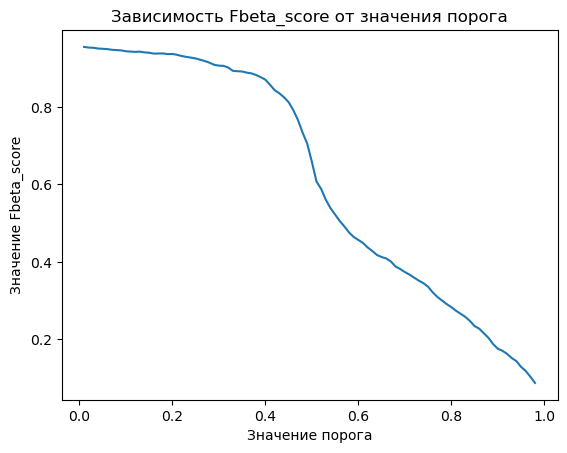

In [83]:
plt.plot(levels, scores)
plt.xlabel("Значение порога")
plt.ylabel("Значение Fbeta_score")
plt.title("Зависимость Fbeta_score от значения порога");

## Интерпретация модели [5 баллов]

Часто нам хочется интерпритировать предсказания модели - понять, как наши признаки влияют на её ответ.
В случае сложных моделей сделать это не просто - чем сложнее модель, тем более сложные закономерности она извлекает и тем тяжелее нам их понять.

Но в случае линейной регресии это просто сделать, посмотрев на её обучаемые параметры (вспоминайте!).

Получите список признаков, которые увеличивают вероятность метки 0.
Аналогично для метки 1.

In [125]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

# Часть 4: ва-банк / пространство для творчества [макс 30 баллов]

Добейтесь максимального качества, больше качество - больше баллов.

Стратегия подготовки данных и обучения модели на ваше усмотрение.

Условия:
* Оценка на отложенной тестовой группе пользователей, использовавшейся в прошлых пунктах (20%)
* В качестве метрики используйте ROC_AUC

__Замечание__: 

Ответа на вопрос "какое нужно качество для максимального балла?" не будет.

Используйте все свои знания, чтобы добиться наилучшего результата.

In [131]:
!pip install xgboost

     --------------------------------------- 70.9/70.9 MB 11.7 MB/s eta 0:00:00


<div class="alert alert-success">
  Проверим, какая мз моделей лучше всего отработает на нашем датасете проверочным путем.
</div>

In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve

In [140]:
model_lr = LogisticRegression().fit(X_train, Y_train)
probs_lr = model_lr.predict_proba(X_test)[:, 1]

model_dt = DecisionTreeClassifier().fit(X_train, Y_train)
probs_dt = model_dt.predict_proba(X_test)[:, 1]

model_rf = RandomForestClassifier().fit(X_train, Y_train)
probs_rf = model_rf.predict_proba(X_test)[:, 1]

model_xg = XGBClassifier().fit(X_train, Y_train)
probs_xg = model_xg.predict_proba(X_test)[:, 1]

In [141]:
auc_lr = roc_auc_score(Y_test, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, probs_lr)

auc_dt = roc_auc_score(Y_test, probs_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(Y_test, probs_dt)

auc_rf = roc_auc_score(Y_test, probs_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, probs_rf)

auc_xg = roc_auc_score(Y_test, probs_xg)
fpr_xg, tpr_xg, thresholds_xg = roc_curve(Y_test, probs_xg)

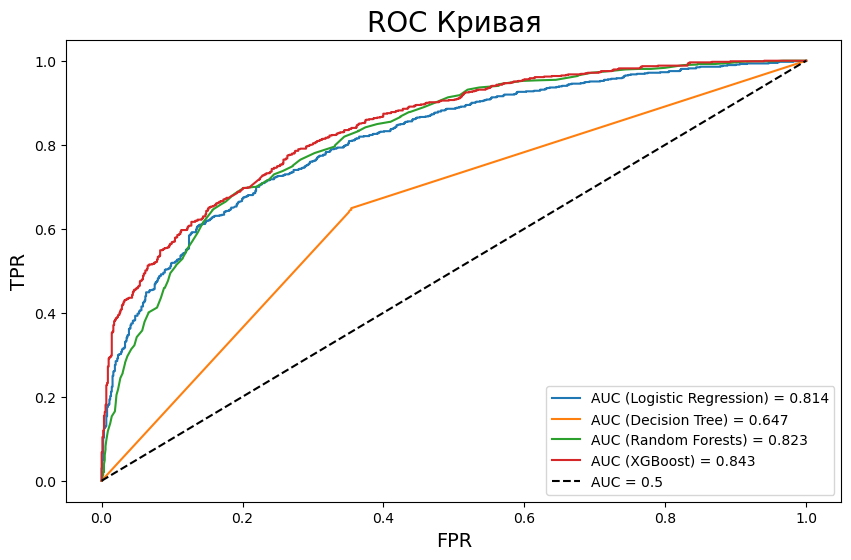

In [145]:
plt.figure(figsize=(10, 6))

plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.3f}')
plt.plot(fpr_dt, tpr_dt, label=f'AUC (Decision Tree) = {auc_dt:.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forests) = {auc_rf:.3f}')
plt.plot(fpr_xg, tpr_xg, label=f'AUC (XGBoost) = {auc_xg:.3f}')

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='AUC = 0.5')
plt.title('ROC Кривая', size=20)
plt.xlabel('FPR', size=14)
plt.ylabel('TPR', size=14)
plt.legend();

<div class="alert alert-success">
 Видим, что лучше всего справилась модельградиентного бустинга - <b>XGBoost</b><br>
 Попробуем потюнить параметры для достижения более хорошего результата.
</div>

In [160]:
model_xg = XGBClassifier(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=200,
    
).fit(X_train, Y_train)
probs_xg = model_xg.predict_proba(X_test)[:, 1]

In [161]:
print(f"ROC AUC SCORE IS {roc_auc_score(Y_test, probs_xg):.3f}")

ROC AUC SCORE IS 0.848


<div class="alert alert-success">
 <h1>Вывод:</h1><br>
 Попробовав несколько вариаций, получилось увеличить знаечние <b>roc_auc_score</b> на 0.5. <br>
 Тут можно попробовать еще запустить <b>GridSearchCV</b>, но слишком долго ждать и комп не тянет просто, о результат есть и это хорошо))
</div>